# Stenosis Classification

This notebook trains classifiers to detect stenosis in MRI scans, using automated labels from the LLM pipeline.

In [1]:
import psutil
import os

process = psutil.Process(os.getpid())

process.cpu_affinity([i for i in range(11)])

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay

ivd_arrays_path = '/work/robinpark/AutoLabelClassifier/data/osclmric_ivd_arrays/april2024_splits'

In [3]:
# Pickle the dictionary
with open(f'{ivd_arrays_path}/osclmric_samples_dict.pkl', 'rb') as handle:
    samples = pickle.load(handle)

In [4]:
train_samples = samples['train_samples']
val_samples = samples['val_samples']
test_samples = samples['test_samples']

In [5]:
# Summarise splits
def sum_samples(samples):
    df = pd.DataFrame.from_dict(samples, orient='index', columns=['results']).reset_index()

    # Split index into columns
    df[['pat_id','date','level']] = df['index'].str.split('_',expand=True)

    # Sum rows by pat_id, date, level, and unique results 
    df = df.groupby(['pat_id','date','level','results']).size().reset_index(name='counts')

    df['pat_id_date'] = df['pat_id'] + '_' + df['date']

    print('unique pat:', len(df[['pat_id']].drop_duplicates()))
    print('unique studies:', len(df[['pat_id_date']].drop_duplicates()))

    display(df.groupby(['results'])[['counts']].sum())

In [6]:
sum_samples(train_samples)

unique pat: 1375
unique studies: 1946


,counts
results,
0,2850
1,2977


In [7]:
sum_samples(val_samples)

unique pat: 153
unique studies: 217


,counts
results,
0,312
1,337


In [8]:
sum_samples(test_samples)

unique pat: 117
unique studies: 123


,counts
results,
0,229
1,139


## ResNet18 Encodings + SVC

In [9]:
with open(f'{ivd_arrays_path}/osclmric_resnet_encodings.pkl', 'rb') as handle:
    osclmric_resnet_encodings = pickle.load(handle)

train_features_cpu = osclmric_resnet_encodings['train_features_cpu']
label_train_array = osclmric_resnet_encodings['label_train_array']

val_features_cpu = osclmric_resnet_encodings['val_features_cpu']
label_val_array = osclmric_resnet_encodings['label_val_array']

test_features_cpu = osclmric_resnet_encodings['test_features_cpu']
label_test_array = osclmric_resnet_encodings['label_test_array']

In [10]:
resnet_clf = make_pipeline(StandardScaler(), svm.SVC(kernel='linear', probability=True))
resnet_clf.fit(train_features_cpu, label_train_array)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear', probability=True))])

In [11]:
def eval_results(clf, val_features, label_val_array, test_features, label_test_array):
    # Predict the validation set
    val_pred = clf.predict(val_features)
    val_prob = clf.predict_proba(val_features)[:, 1]

    # Evaluate using AUROC, F1 and balanced accuracy
    val_auc = roc_auc_score(label_val_array, val_prob)
    val_f1 = f1_score(label_val_array, val_pred)
    val_bal_acc = balanced_accuracy_score(label_val_array, val_pred)
    val_acc = np.mean(val_pred == label_val_array)

    fpr, tpr, thresholds = roc_curve(label_val_array, val_prob)

    # Find the point where FPR equals FRR
    val_eer_threshold = thresholds[np.nanargmin(np.absolute((1 - tpr) - fpr))]
    val_eer = fpr[np.nanargmin(np.absolute((1 - tpr) - fpr))]  # Equal to FRR

    print(f'Val Accuracy: {val_acc:.3f}')
    print(f'Val AUC: {val_auc:.3f}')
    print(f'Validation F1: {val_f1:.3f}')
    print(f'Validation Balanced Accuracy: {val_bal_acc:.3f}')
    print(f'EER: {val_eer:.3f}')
    print(f'EER Threshold: {val_eer_threshold:.3f}\n')

    # Predict test set
    test_prob = clf.predict_proba(test_features)[:, 1]

    fpr, tpr, thresholds = roc_curve(label_test_array, test_prob)

    # Find the point where FPR equals FRR
    test_eer_threshold = thresholds[np.nanargmin(np.absolute((1 - tpr) - fpr))]
    test_eer = fpr[np.nanargmin(np.absolute((1 - tpr) - fpr))]  # Equal to FRR

    test_pred = test_prob > val_eer_threshold

    # Evaluate using accuracy, F1 and balanced accuracy
    test_auc = roc_auc_score(label_test_array, test_prob)
    test_f1 = f1_score(label_test_array, test_pred)
    test_bal_acc = balanced_accuracy_score(label_test_array, test_pred)
    test_acc = np.mean(test_pred == label_test_array)

    print(f'Test Accuracy: {test_acc:.3f}')
    print(f'Test AUC: {test_auc:.3f}')
    print(f'Test F1: {test_f1:.3f}')
    print(f'Test Balanced Accuracy: {test_bal_acc:.3f}')
    print(f'EER: {test_eer:.3f}')
    print(f'EER Threshold: {test_eer_threshold:.3f}')

    display_labels = ['No Stenosis', 'Stenosis']
    class_report = classification_report(label_test_array, test_pred, target_names=display_labels)
    conf_mat = confusion_matrix(label_test_array, test_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                  display_labels=display_labels)

    print(class_report)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return test_pred, test_prob

Val Accuracy: 0.735
Val AUC: 0.802
Validation F1: 0.747
Validation Balanced Accuracy: 0.734
EER: 0.266
EER Threshold: 0.514

Test Accuracy: 0.774
Test AUC: 0.836
Test F1: 0.722
Test Balanced Accuracy: 0.775
EER: 0.227
EER Threshold: 0.517
              precision    recall  f1-score   support

 No Stenosis       0.85      0.77      0.81       229
    Stenosis       0.68      0.78      0.72       139

    accuracy                           0.77       368
   macro avg       0.76      0.77      0.77       368
weighted avg       0.78      0.77      0.78       368



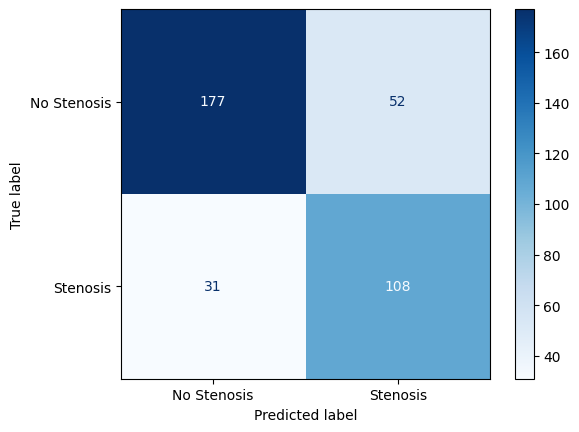

In [12]:
test_pred, test_prob = eval_results(resnet_clf, val_features_cpu, label_val_array, test_features_cpu, label_test_array)

## SpineNetv2 Classifier

In [13]:
with open(f'{ivd_arrays_path}/osclmric_spinenet_encodings.pkl', 'rb') as handle:
    osclmric_spinenet_encodings = pickle.load(handle)

ivd_train_encodings = osclmric_spinenet_encodings['ivd_train_encodings'] 
label_train_array = osclmric_spinenet_encodings['label_train_array'] 

ivd_val_encodings = osclmric_spinenet_encodings['ivd_val_encodings'] 
label_val_array = osclmric_spinenet_encodings['label_val_array'] 
spnt_label_val_array = osclmric_spinenet_encodings['spnt_label_val_array'] 

ivd_test_encodings = osclmric_spinenet_encodings['ivd_test_encodings'] 
label_test_array = osclmric_spinenet_encodings['label_test_array']
spnt_label_test_array = osclmric_spinenet_encodings['spnt_label_test_array']


In [14]:
# Classifier performance 
acc = (np.array(spnt_label_test_array) == np.array(label_test_array)).sum() / len(label_test_array)
bal_acc = balanced_accuracy_score(label_test_array, spnt_label_test_array)
f1 = f1_score(label_test_array, spnt_label_test_array)
print(f'Balanced Accuracy: {bal_acc:.3f}')
print(f'F1: {f1:.3f}')

Balanced Accuracy: 0.679
F1: 0.574


## SpineNetv2 Encodings + SVC

In [15]:
# Initialize SVM classifier
spnv2_clf = make_pipeline(StandardScaler(), svm.SVC(kernel='linear', probability=True))

# Train the classifier
spnv2_clf.fit(ivd_train_encodings, label_train_array)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear', probability=True))])

Val Accuracy: 0.735
Val AUC: 0.810
Validation F1: 0.750
Validation Balanced Accuracy: 0.734
EER: 0.260
EER Threshold: 0.522

Test Accuracy: 0.788
Test AUC: 0.858
Test F1: 0.727
Test Balanced Accuracy: 0.780
EER: 0.218
EER Threshold: 0.500
              precision    recall  f1-score   support

 No Stenosis       0.84      0.81      0.83       229
    Stenosis       0.71      0.75      0.73       139

    accuracy                           0.79       368
   macro avg       0.77      0.78      0.78       368
weighted avg       0.79      0.79      0.79       368



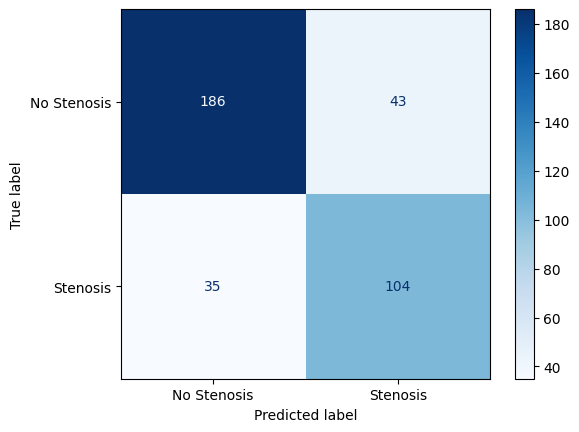

In [16]:
spnv2_test_pred, spnv2_test_prob = eval_results(spnv2_clf, ivd_val_encodings, label_val_array, ivd_test_encodings, label_test_array)

## Visualise Resnet18 Encodings + SVC Results

In [17]:
# Load pickled arrays
with open(f'{ivd_arrays_path}/osclmric_arrays_dict.pkl', 'rb') as handle:
    osclmric_array_dict = pickle.load(handle)

ivd_train_array = osclmric_array_dict['ivd_train_array']
label_train_array = osclmric_array_dict['label_train_array']

ivd_val_array = osclmric_array_dict['ivd_val_array']
label_val_array = osclmric_array_dict['label_val_array']

ivd_test_array = osclmric_array_dict['ivd_test_array']
label_test_array = osclmric_array_dict['label_test_array']
label_test_report = osclmric_array_dict['label_test_report']
label_test_scores = osclmric_array_dict['label_test_scores']
label_test_con = osclmric_array_dict['label_test_con']
compare_test_array = osclmric_array_dict['compare_test_array']

In [18]:
# counter = 4
# zipped_results = list(zip(label_test_report, label_test_con, label_test_scores, compare_test_array, label_test_array, test_pred, test_prob, ivd_test_array))
# for report, pred_con, pred_report_score, pred_report_label, true_report_label, pred_scan_label, pred_scan_score, ivd in zipped_results:
#     if counter < 5:
#         print(f'Report: {report}')
#         print(f'Conclusion: {pred_con}')
#         print(f'Predicted Report Score: {pred_report_score}')
#         print(f'Predicted Report Label: {pred_report_label}')
#         print(f'True Report Label: {true_report_label}')
#         print(f'Predicted Scan Label: {pred_scan_label}')
#         print(f'Predicted Scan Score: {pred_scan_score}')
#         # Plot ivd
#         plt.imshow(ivd[0,3,:,:], cmap='gray')
#         plt.show()
#         print('\n')
#         counter -= 1
#     elif counter == 0:
#         break